In [51]:
%reset

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

from quantum_systems import ODQD, GeneralOrbitalSystem

In [53]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 101  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
omega = 0.25  # The frequency of the harmonic oscillator trap
potential=ODQD.HOPotential(omega)
nparticles = 2

odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential )
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=True)

In [54]:
def plot_AO(odho): #can be called only after creation of odho and before creation of system!!!
    plt.figure(figsize=(8, 5))
    plt.plot(odho.grid, potential(odho.grid))

    for i in range(l):
        plt.plot( odho.grid, np.abs(odho.spf[i]) ** 2 + odho.h[i, i].real, label=r"$\chi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()

def plot_MO(system, epsilon, C):
    plt.figure(figsize=(12,8))
    plt.plot(system.grid, potential(system.grid))

    for i in range(len(C)):
        to_plot = np.zeros( system.grid.shape, np.complex64 )
        for j in range(len(C)):
            to_plot += system.spf[j] * C[j,i]
        plt.plot( system.grid,  np.abs(to_plot)**2 + epsilon[i], label=r"$\phi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()


def plot_MO_abc(system, epsilon):
    plt.figure(figsize=(12, 8))
    plt.plot(system.grid, potential(system.grid))

    for i in range(len(epsilon)):
        plt.plot( system.grid, np.abs(system.spf[i]) ** 2 + epsilon[i], label=r"$\chi_{" + f"{i}" + r"}$" )

    plt.grid()
    plt.legend()
    plt.show()

def solve_HF(system, nparticles, tolerance, max_iter):
    i = 0
    f = np.zeros( system.h.shape, dtype=np.complex64 )
    epsilon, C = scipy.linalg.eigh(system.h)
    epsilon_old = epsilon
    density = evaluate_density_matrix(nparticles, C)
    deltaE=1

    while i<max_iter and deltaE>tolerance:
        f = np.zeros( system.h.shape, dtype=np.complex64 )
        density = evaluate_density_matrix(nparticles, C)

        for a in range(len(system.h)):
            for b in range(len(system.h)):

                for c in range(len(system.h)):
                    for d in range(len(system.h)):
                        f[a,b] += density[c,d] * system.u[a,c,b,d]

        f += system.h
        epsilon, C = scipy.linalg.eigh(f)
        deltaE = sum(np.abs(epsilon - epsilon_old))/len(system.h)
        epsilon_old = epsilon
        i+=1

    return epsilon, C
    

def evaluate_density_matrix(nparticles, coefficients):
    density = np.zeros( coefficients.shape, dtype=np.complex64)

    for i in range(nparticles):
        density += np.outer( coefficients[:,i], np.conjugate(coefficients[:,i]))
    
    return density

def total_energy(system, epsilon):
    energy = 0
    for i in range(2):
        for j in range(2):
            energy -= system.u[i,j,i,j] 
    
    energy = energy*0.5 + sum(epsilon[0:2])
    return energy

In [55]:
epsilon, C = solve_HF(system, nparticles=nparticles, tolerance=1e-12, max_iter=20)
system.change_basis(C)

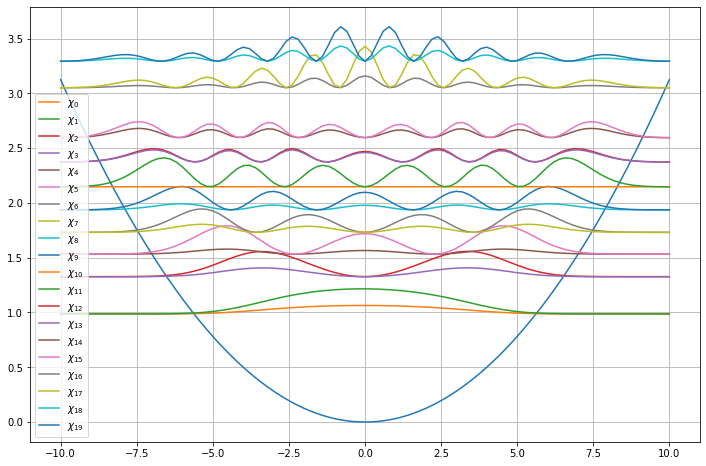

In [56]:
plot_MO_abc(system,epsilon)

In [58]:
print(total_energy(system,epsilon))

(1.1784528221259876+0j)
